In [ ]:
#@title Libraries
import numpy as np
import unittest
import glob
import os
import matplotlib.pyplot as plt

In [ ]:
#@title initialize
def initialize(path,testratio=0.3):
    # Here we take the file and store them in the list.
    # we the sort the list containing files in order and store in filespaths and labels in labelspaths.
    filespaths = list(np.sort(glob.glob(path+"//*graph.txt")))
    labelspaths = list(np.sort(glob.glob(path+"//*label.txt")))
    # we filelist to True
    filelist=True
    # we find the length of the filespaths list : this can be used in other fuction
    size = len(filespaths)
    # we took testratio and substracted it from size so that we can divide some for testing and some for training.
    trainindexend = size - int(testratio*size)
    # we return the filespaths and labelspaths and trainindexend
    return filespaths, labelspaths, trainindexend

In [ ]:
#@title graphreaderbatch
# here we the filespaths list and set filelist to False
def graphreaderbatch(filespath,filelist=False):
    # Here we check if the files are in dict of lists or lists
    # if it is dict of lists then changes to list
    if filelist :
        filespaths = filespath['data']
        labelspaths = filespath['label']
    # Else directly list will store in the given variables.
    else :
        filespaths = glob.glob(filespath+"//*graph.txt")
        labelspaths = glob.glob(filespath+"//*label.txt")
    # here numexamples is the length of the labelslist
    numexamples = len(labelspaths)
    # here we initialize first with empty list to store adjacency matrix
    adj = []
    # here we initialize first with empty  list to store number of nodes in the graph
    nnodes = []
    # here we initialize first with empty  list to store number of nodes in the graph
    labels = []

    # Here we append the adjacent matrix and number of nodes in the graph.txt file to the adj list and nnodes listcoorespondingly.
    for i in range (len(filespaths)):
        adj.append(np.loadtxt(filespaths[i],skiprows=1))
        nnodes.append(int(open(filespaths[i]).readline().rstrip()))

    # Here we append the labels in the label.txt file to the labels list.
    if len(labelspaths) != 0:
        for i in range (len(labelspaths)):
            labels.append(int(open(labelspaths[i]).readline().rstrip()))
    # here we return the adjacency matrix, nnodes, labels, numexamples.
    return adj, nnodes, labels, numexamples

In [ ]:
#@title graphdatasetinit
def graphdatasetinit(path,filelist=False):
    # we can this function to read the adjacency matrix, number of nodes and the labels.
    adj, nnodes, labels, numexamples = graphreaderbatch(path,filelist)
    # we store adjacency matrix in array format
    adj = np.array(adj,dtype=object)
    # we store labels in array format
    labels = np.array(labels)
    # we store number nodes in array format
    nnodes = np.array(nnodes)
    # we initilize the index in the epoch to 0
    indexinepoch = 0
    epochcompleted = 0
    # here we calcalate the length of the adjacency matrix list and store in numexamples.
    numexamples = int(len(adj))
    #return all parameters
    return adj, nnodes, labels, indexinepoch, epochcompleted, numexamples

In [ ]:
#@title gettrain_
def gettrain_(filespaths,labelspaths,trainindexend):
    # here we seperate the graphs from 0 to 7 for training part by slicing.
    trainpaths = {'data':filespaths[:trainindexend],
                    'label':labelspaths[:trainindexend] }
    filelist = True
    # Here we call the graphdataset to read the data from training list files.
    train_adj, train_nnodes, train_labels, train_indexinepoch, train_epochcompleted, train_numexamples = graphdatasetinit(trainpaths,filelist)

    # we return the object of the class.
    return trainpaths, train_adj, train_nnodes, train_labels, train_indexinepoch, train_epochcompleted, train_numexamples

In [ ]:
#@title gettest_
def gettest_(filespaths,labelspaths,trainindexend):
    # here we seperate the graphs from 7 to end of the list for testing part by slicing.
    testpaths  = {'data':filespaths[trainindexend:],
                    'label':labelspaths[trainindexend:] }
    filelist = True
    # Here we call the graphdataset to read the data from testing list files.
    test_adj, test_nnodes, test_labels, test_indexinepoch, test_epochcompleted, test_numexamples = graphdatasetinit(testpaths,filelist)

    # we return the object of the class.
    return testpaths, test_adj, test_nnodes, test_labels, test_indexinepoch, test_epochcompleted, test_numexamples

In [ ]:
#@title graphdatasetnextbatch
def graphdatasetnextbatch(batchsize, adj, nnodes, labels, indexinepoch, epochcompleted, numexamples, shuffle=True):
    # we take start variable and assign indexinepoch.
    start = indexinepoch

    #Here we check this condidtion and arange and shuffle the graphs list.
    if start == 0 and epochcompleted == 0 :
        idx = np.arange(0,numexamples)
        np.random.shuffle(idx)
        adj    = adj[idx]
        labels = labels[idx]
        nnodes = nnodes[idx]

    # Here we check the condition divide the list of graphs into batchsize
    if start+batchsize <= numexamples:
        indexinepoch += batchsize
        end = indexinepoch
        adjbatch = adj[start:end]
        labelsbatch = labels[start:end]
        nnodesbatch = nnodes[start:end]
        #Here we return the adjacency matrix, label list, nnodes list of batchsize.
        return adjbatch,nnodesbatch,labelsbatch

    else :
        epochcompleted += 1
        restnumexamples = numexamples - start

        adjrest = adj[start:numexamples]
        labelsrest  = labels[start:numexamples]
        nnodesrest = nnodes[start:numexamples]

        idx0 = np.arange(0,numexamples)
        np.random.shuffle(idx0)
        adj = adj[idx0]
        labels = labels[idx0]
        nnodes = nnodes[idx0]

        start = 0
        indexinepoch = batchsize - restnumexamples
        end = indexinepoch

        adjnew = adj[start:end]
        labelsnew = labels[start:end]
        nnodesnew = nnodes[start:end]

        adjbatch = np.concatenate((adjrest,adjnew),axis=0)
        labelsbatch = np.concatenate((labelsrest,labelsnew),axis=0)
        nnodesbatch = np.concatenate((nnodesrest,nnodesnew),axis=0)
        #Here we return the adjacency matrix, label list, nnodes list of batchsize.
        return adjbatch,nnodesbatch,labelsbatch

In [ ]:
#@title gnninitialize
def gnninitialize(D):
    """
    initialization, takes hyper param T and D
    T : aggregation step and D : feature vector size
    W, A, b : parameters of the network. W and A is
                initialized using normal distribution
                with sigma = 0.4 and mean = 0
    dLdW, dLdA, dLdb : gradient of the parameters
    """
    sigma = 0.4
    W = sigma * np.random.randn(D,D)
    A = sigma * np.random.randn(D)
    b = 0
    dLdW = np.zeros((D,D))
    dLdA = np.zeros((D))
    dLdb = 0
    return W, A, dLdW, dLdA, b, dLdb

In [ ]:
#@title aggregation1
def aggregation1(X,adj):
    """
    Function to calculate aggregation 1, the adjacency
    matrix is used to represent the nodes connections
    within the graph
    Args :
        X   : Feature matrix
        adj : Adjacency matrix representing the Graph

    Return :1
        a = sum of feature matrix
    """
    a = np.dot(adj,X)
    return a

In [ ]:
#@title aggregation2
def aggregation2(W,a):
    """
    Function to calculate aggregation 2, here transpose
    is used to easily calculating the aggregation using
    dot product
    Args :
        W : D x D weight matrix
        a : Output of aggregation1

    Return :
        x : W . a
    """
    x = np.dot(W,np.transpose(a))
    x = np.transpose(x)
    return x

In [ ]:
#@title relu
def relu(inp):
    """
    Rectifier Linear Unit Function, max(0,inp)
    """
    out = np.maximum(inp,1)
    return out

In [ ]:
#@title readout
def readout(X):
    """
    Function to sum all node's feature vectors
    Args :
        X : Feature vectors
    Return :
        hG : Sum of all feature vectors
    """
    hG = np.sum(X,axis=0)
    return hG

In [ ]:
#@title so
def so(hG,A,b):
    """
    Predictor function with parameter A and b
    Args :
        hG : last output of aggregation module
        A  : D size parameter
        b  : bias of predictor function
    Return :
        s : output of predictor function
    """
    s1 = np.dot(hG,A)+b
    return s1


In [ ]:
#@title sigmoid
def sigmoid(s):
        p = 1/(1+np.exp(-s))
        return p

In [ ]:
#@title output
def output(p):
    """
    output the predicted class
    Args :
        p : output of sigmoid function
    Return :
        out : predicted class 0 or 1

    """
    out = np.where((p>0.5),1,0)
    return out


In [ ]:
#@title forward
def forward(nnodes, adj, D, W, A, b, T):
    """
    forward method to calculate forward propagation of the nets
    Args :
        nnodes  : number of nodes in the batch
        adj     : adjacency matrix
        W       : parameter matrix W
        A       : parameter vector A
        b       : bias b
    Return :
        slist       : vector of predictor value
        output list : vector of predicted class`
    """
    slist = []
    outputlist = []

    X = []

    # feature vector definition
    feat =  np.zeros(D)
    feat[0] = 1

    tempnnodes = nnodes
    tempadj = adj

    for i in range(adj.shape[0]):
        X.append(np.tile(feat,[nnodes[i],1]))
        for j in range(T):
            a = aggregation1(X[i],adj[i])
            x = aggregation2(W,a)
            out = relu(x)
            X[i] = out
        # we sum the column elements
        hG = readout(X[i])
        # From here it is same as simple neural network
        s = so(hG,A,b)       # Linear part
        p = sigmoid(s)       # y_hat
        output1 = output(p)  # 0/1 value for the binary classification
        slist.append(s)
        outputlist.append(int(output1))
    return slist,outputlist, tempnnodes, tempadj

In [ ]:
#@title loss
def loss(s,y):
    """
    loss function
    Args :
        s   : vector of predictor values
        y   : vector of true class labels
    Return :
        losslist : vector of loss values
    """
    losslist = []
    for i in range (len(s)):
        if np.exp(s[i]) > np.finfo(type(np.exp(s[i]))).max:
            loss = y[i]*np.log(1+np.exp(-s[i])) + (1-y[i]) * s[i] #avoid overflow
        else :
            loss = y[i]*np.log(1+np.exp(-s[i])) + (1-y[i]) * np.log(1+np.exp(s[i]))
        losslist.append(loss)

    return losslist

In [ ]:
#@title backward
def backward(loss1, y, epsilon, tempnnodes, tempadj, D, W, A, b):
    """
    Backpropagation function to calculate and update
    the gradient of the neural network
    Args :
        loss    : loss vector
        y       : true class label
        epsilon : small pertubation value for numerical
                    differentiation

    """
    tempdLdW = np.zeros((D,D))
    tempdLdA = np.zeros((D))
    tempdLdb = 0
    batchsize = len(loss1)

    for i in range (D):
        for j in range (D):
            deltaW = np.zeros((D,D))
            deltaW[i,j] = epsilon
            Wepsilon = W+deltaW
            W = Wepsilon            # updated W based on epsilon
            sep, _, tempnnodes, tempadj = forward(tempnnodes, tempadj, D, W, A, b, T)
            lossep = loss(sep,y)
            for k in range(batchsize):
                tempdLdW[i,j] += (lossep[k] - loss1[k])/epsilon
            tempdLdW[i,j] = tempdLdW[i,j]/batchsize

    for i in range (D):
        deltaA = np.zeros((D))
        deltaA[i] = epsilon
        Aepsilon = A + deltaA
        A=Aepsilon
        sep, _, tempnnodes, tempadj = forward(tempnnodes, tempadj, D, W, A, b,T)
        lossep = loss(sep,y)
        for j in range(batchsize):
            tempdLdA[i] += (lossep[j] - loss1[j])/epsilon
        tempdLdA[i] = tempdLdA[i]/batchsize

    bepsilon = b + epsilon
    b=bepsilon
    sep, _, tempnnodes, tempadj = forward(tempnnodes, tempadj, D, W, A, b, T)
    lossep = loss(sep,y)
    for i in range(batchsize):
        tempdLdb += (lossep[i] - loss1[i])/epsilon
    tempdLdb = tempdLdb/batchsize

    dLdW = tempdLdW
    dLdA = tempdLdA
    dLdb = tempdLdb
    return dLdW, dLdA, dLdb

In [ ]:
#@title SGD
def SGD(lr, W, A, b, dLdW,dLdA,dLdb):
    newW = W - lr*dLdW
    newA = A - lr*dLdA
    newb = b - lr*dLdb
    W, A, b = newW,newA,newb
    return W, A, b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Parameters

#path = "/content"
path = "/content/drive/MyDrive/Datasets/datasets/My_Dataset/My_Dataset"  #path of the dataset
batchsizetrain = 500  # 65
T = 1          # Number of aggregation steps #1
D = 2              # Dimension of feature vectors #2
#optimizer = "SGD"  # Optimization methods
lr = 0.000005        # Learning rate #0.0005
#momentum  = 0.2   # Parameter for SGDM optimizer
epoch     = 300     # 500
epsilon   = 0.5      # some parameter related to learning rate    #0.5

In [ ]:
#@title GNN

#initialized the path : here we input the path to .txt files which contain
#the adjacency matrix and a label.
filespaths, labelspaths, trainindexend = initialize(path)

# here we call this function to seperate list : 0:6 for training and 7: end for testing.
# here all the paths and training parameters,testing parameters
trainsetpaths, trainset_adj, trainset_nnodes, trainset_labels, trainset_indexinepoch, trainset_epochcompleted, trainset_numexamples = gettrain_(filespaths,labelspaths,trainindexend)
testsetpaths, testset_adj, testset_nnodes, testset_labels, testset_indexinepoch, testset_epochcompleted, testset_numexamples = gettest_(filespaths,labelspaths,trainindexend)

# Initialize the all the variables
W, A, dLdW, dLdW, dLdb, b  = gnninitialize(D)

print("W :",W)
print("A :",A)
print("b :",b)

W : [[-0.41755743 -0.33351055]
 [ 0.52686262  0.22713625]]
A : [-0.3613471   0.63725958]
b : 0


In [ ]:
#@title Training set

# Initializing empty list to store losses and accutacies.
trainlosses = []
trainaccuracies = []
trainy_hat = []
trainy = []
train_epoch = 0

while train_epoch < epoch:
  train_adj, train_nnodes, train_labels = graphdatasetnextbatch(batchsizetrain, trainset_adj, trainset_nnodes, trainset_labels, trainset_indexinepoch, trainset_epochcompleted, trainset_numexamples)

  # Forward propagation
  train_s,train_ ,tempnnodes, tempadj = forward(train_nnodes, train_adj, D, W, A, b, T)

  # Loss
  train_losss = loss(train_s,train_labels)  # In general neural networks we are using y_hat for the loss function
  #calculation but here s = z, the linear part is using to calculate the loss function

  # Backward propagation
  dLdW, dLdA, dLdb = backward(train_losss, train_labels, epsilon, tempnnodes, tempadj, D, W, A, b)

  # Updating W, A, b
  W, A, b = SGD(lr, W, A, b, dLdW,dLdA,dLdb)

  trainloss = np.average(train_losss)
  trainright = np.sum(np.array(train_) == np.array(train_labels))
  trainacc = trainright/len(train_)

  trainlosses.append(trainloss)
  trainaccuracies.append(trainacc)
  trainy_hat.append(train_)
  trainy.append(train_labels)
  train_epoch += 1

  print("epoch ",train_epoch)
  print("W :",W)
  print("A :",A)
  print("b :",b)

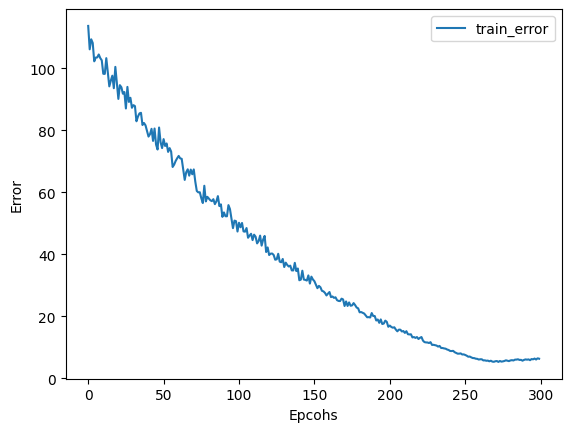

In [ ]:
x_axis = [i for i in range(epoch)]
plt.plot(x_axis , trainlosses, label='train_error')
plt.legend()
plt.xlabel("Epcohs")
plt.ylabel("Error")
plt.savefig('My_Dataset_errorVSepoch.png')
plt.show()

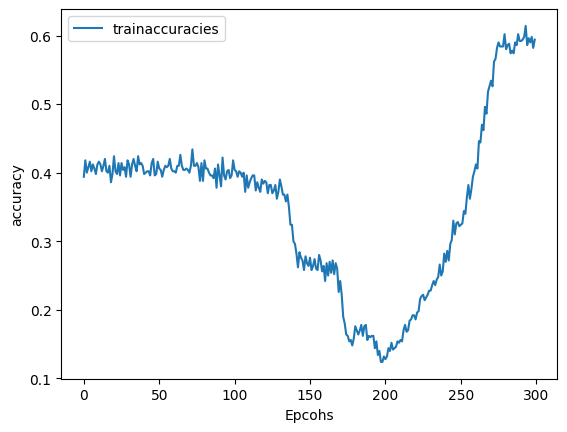

In [ ]:
epoch = 300
x_axis = [i for i in range(epoch)]
plt.plot(x_axis , trainaccuracies, label='trainaccuracies')
plt.legend()
plt.xlabel("Epcohs")
plt.ylabel("accuracy")
plt.savefig('My_Dataset_errorVSaccuracy.png')
plt.show()

In [ ]:
#  W, A, b

batchsizetest = 300
#test_adj, test_nnodes, test_labels = graphdatasetnextbatch(batchsizetest, testset_adj, testset_nnodes, testset_labels, testset_indexinepoch, testset_epochcompleted, testset_numexamples)
test_adj, test_nnodes, test_labels = graphdatasetnextbatch(batchsizetest, trainset_adj, trainset_nnodes, trainset_labels, trainset_indexinepoch, trainset_epochcompleted, trainset_numexamples)
# Forward propagation
test_s,test_ ,tempnnodes, tempadj = forward(test_nnodes,test_adj, D, W, A, b, T)

In [ ]:
countequal  = 0
countunequal = 0

for i in range(len(test_)):
  if test_[i] == train_labels[i]:
    countequal += 1
  else:
    countunequal += 1

print(countequal)
print(countunequal)

56
44
